# **1. Import Library**

In [ ]:
!pip install bertopic nltk bertopic[use]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [ ]:
!pip install huggingface-hub==0.25.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [ ]:
import numpy as np
import pandas as pd
import re
import string
import torch
import seaborn as sns
import matplotlib.pyplot as plt

import logging
import nltk
from nltk import word_tokenize
from gensim.corpora.dictionary import Dictionary
import gensim
from gensim import corpora
from wordcloud import WordCloud

from tqdm.notebook import tqdm
tqdm.pandas()

# **2. Document Preparation**

In [ ]:
topic_df = pd.read_csv('https://raw.githubusercontent.com/najwhoas/bnpl-knowledge-mining-paper/refs/heads/main/data/BNPL--Original-Dataset.csv')

In [ ]:
# Recleaning irrelevant words
# List of banned words to be removed from the text data
bannedword = [
    'moga', 'shopeepay', 'gopaylater', 'sdah', 'sih', 'spinjam', 'hci', 'ovopaylater', 'shopee', 'tokopedia',
    'paylater', 'shoope', 'shoppe', 'shope', 'tolong', 'kayak', 'ongkos', 'kirim', 'mohon', 'aplikasi', 'nya',
    'banget', 'akulaku', 'kredivo', 'kreivo', 'kredivoo', 'kridivo', 'ayo', 'ya', 'bintang', 'indodana', 'bca',
    'aamiin', 'shopintar', 'terima', 'kasih', 'kali', 'kemarin', 'cuman', 'alhamdulillah', 'go', 'grab', 'alfamart',
    'alfamidi', 'indomaret', 'deposito', 'ovo', 'ovi', 'ktanya', 'x4jam', 'bank', 'haha', 'pulsa', 'token',
    'listrik', 'pln', 'paylaternya'
]

# Adjust regex
# Create a regex pattern to match any of the banned words (case-insensitive)
# The pattern uses word boundaries (\b) to ensure whole words are matched
re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + r")\b", re.I)

def remove_banned_word(text):
    """
    Removes banned words from the input text using a predefined regex pattern.

    Args:
        text (str): The input text from which banned words need to be removed.

    Returns:
        str: The cleaned text with all banned words removed.
    """
    global re_banned_words
    return re_banned_words.sub("", text)  # Substitute banned words with an empty string

# Apply the `remove_banned_word` function to the 'lemmatized' column in the DataFrame
# Convert each entry to a string (in case of non-string data) and remove banned words
topic_df['lemmatized'] = topic_df['lemmatized'].apply(lambda x: remove_banned_word(str(x)))

In [ ]:
# Build documents
docs = topic_df['lemmatized'].dropna().to_list()

In [ ]:
topic_df['period'] = pd.to_datetime(topic_df['period'])
periods = topic_df['period'].dropna().to_list()

# **3. Topic Modeling**

In [ ]:
# Import the SentenceTransformer class from the sentence_transformers library
# This library provides pre-trained models for generating sentence embeddings
from sentence_transformers import SentenceTransformer

# Encode documents into embeddings using a pre-trained SentenceTransformer model

# Initialize the SentenceTransformer model
# The model used here is "firqaaa/indo-sentence-bert-base", which is a pre-trained model specifically fine-tuned for Indonesian language tasks. It generates dense vector representations (embeddings) for input sentences or documents.
sentence_model = SentenceTransformer("firqaaa/indo-sentence-bert-base")

# Encode the input documents into embeddings
# - `docs`: A list of text documents (strings) to be encoded into embeddings.
# - `show_progress_bar=True`: Displays a progress bar during the encoding process to indicate progress.
embeddings = sentence_model.encode(docs, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/141 [00:00<?, ?it/s]

In [ ]:
# Import the UMAP class from the umap-learn library
# UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional space (e.g., 2D or 3D).
from umap import UMAP

# Initialize the UMAP model with specific hyperparameters
# - `n_neighbors=30`: Controls the number of neighboring points used to approximate the manifold structure.
#   A higher value focuses on global structure, while a lower value preserves local structure.
# - `n_components=10`: The number of dimensions in the reduced space. Here, embeddings are reduced to 10 dimensions.
# - `min_dist=0.0`: Controls the minimum distance between points in the reduced space. A value of 0.0 allows points to be closer together.
# - `metric='cosine'`: The distance metric used to measure similarity between points. Cosine similarity is chosen because it is well-suited for text embeddings.
umap_model = UMAP(n_neighbors=30, n_components=10, min_dist=0.0, metric='cosine')

# Apply UMAP to reduce the dimensionality of the embeddings
# - `embeddings`: The high-dimensional input data (e.g., sentence embeddings) to be reduced.
# - `fit_transform()`: Fits the UMAP model to the data and transforms it into the lower-dimensional space.
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Import the HDBSCAN class from the hdbscan library
# HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups data points based on density and is robust to noise and varying cluster densities.
from hdbscan import HDBSCAN

# Initialize the HDBSCAN model with specific hyperparameters
# - `metric='cosine'`: The distance metric used to measure similarity between data points. Cosine distance is chosen because it is well-suited for text embeddings, as it focuses on the orientation (angle) of vectors rather than their magnitude.
# - `cluster_selection_method='eom'`: Specifies the method used to select clusters from the hierarchy. "eom" (Excess of Mass) is a robust method that balances cluster stability and density.
# - `prediction_data=True`: Enables the model to store additional data required for predicting cluster labels for new points after the model has been trained. This is useful for assigning clusters to unseen data points later.
hdbscan_model = HDBSCAN(metric='cosine', cluster_selection_method='eom', prediction_data=True)

In [ ]:
# Import the KeyBERTInspired class from the bertopic.representation module
# KeyBERTInspired is a representation model used in BERTopic to generate topic representations by extracting key phrases or terms that best describe each topic. It is inspired by the KeyBERT library, which leverages Maximal Marginal Relevance (MMR) and BERT embeddings to identify the most relevant terms in a document or topic.
from bertopic.representation import KeyBERTInspired

# Initialize the KeyBERTInspired representation model
# This model will be used to generate human-readable topic representations by extracting key phrases or terms from the documents within each topic. It uses BERT embeddings to identify the most relevant terms based on their semantic similarity to the topic.
representation_model = KeyBERTInspired()

In [ ]:
print(docs[:10])  # Print the first 10 documents

['spam telpon promosi ajak buka akun ', 'buruk bayar iklan muncul ganggu ganggu buang', 'satu sedia tarik kartu kredit kartu bunga kartu kredit', ' sms  pilih limit serta link unduh   1 detik daftar aju tolak tipu hebat pasang', 'indosat im3  pesan sampah daftar pinjam langsung isi formulir pinjam uang curi data', ' baik mudah', 'error jaring foto ktp aktivasi dana instan uang guna', 'sms masuk coba aktif gagal coba kecewa', 'promosi janji busuk', 'solusi bayar praktis terpercaya proses daftar mudah limit cepat tuju transaksi daring offline bunga kompetitif tenor cicil fleksibel buat bantu butuh desak layan langgan responsif ramah puas mudah hidup']


In [ ]:
from bertopic import BERTopic

# BERTopic topic modeling
topic_model = BERTopic(representation_model=representation_model,
                       embedding_model=sentence_model,
                       nr_topics='auto', # nr_topics="auto" to automatically reduce the cluster
                       calculate_probabilities=True,
                       n_gram_range=(1, 2),
                       verbose=True,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model)

# fit and transform data
topics, _ = topic_model.fit_transform(docs, embeddings)

2025-01-13 14:52:12,158 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-13 14:52:24,621 - BERTopic - Dimensionality - Completed ✓
2025-01-13 14:52:24,624 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-13 14:52:25,344 - BERTopic - Cluster - Completed ✓
2025-01-13 14:52:25,347 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-13 14:52:28,068 - BERTopic - Representation - Completed ✓
2025-01-13 14:52:28,070 - BERTopic - Topic reduction - Reducing number of topics
2025-01-13 14:52:30,103 - BERTopic - Topic reduction - Reduced number of topics from 48 to 36


In [ ]:
# Retrieve topic information from the BERTopic model
# The `get_topic_info()` method returns a DataFrame containing details about each topic, such as the topic ID, the number of documents assigned to the topic, and the topic's name or label.
# The DataFrame is sorted by the "Topic" column in ascending order to ensure topics are ordered numerically.
topic_info = topic_model.get_topic_info().sort_values("Topic", ascending=True)

# Extract topic labels from the topic information DataFrame
# - `topic_info['Name']`: Retrieves the column containing the names or labels of the topics.
# - `.tolist()[1:]`: Converts the column to a list and skips the first row, which typically corresponds to the outlier topic (topic ID = -1). Outliers are documents that do not belong to any specific topic.
labels = topic_info['Name'].tolist()[1:]

# Add 'Topic' and 'Label' columns to existing DataFrame
# - `topic_df['topic']`: Adds a new column to the DataFrame `topic_df` containing the topic IDs assigned to each document. The `topics` variable is a list of topic IDs generated by the BERTopic model.
# - `topic_df['cluster']`: Adds a new column to the DataFrame `topic_df` containing the topic labels.
#   The list comprehension iterates through the `topics` list and maps each topic ID to its corresponding label from the `labels` list. If a document is an outlier (topic ID = -1), it is assigned the label 'Outlier'.
topic_df['topic'] = topics
topic_df['cluster'] = [labels[topic] if topic != -1 else 'Outlier' for topic in topics]

In [ ]:
# Get the topic information
topic_info = topic_model.get_topic_info()

# Iterate over the clusters (topics)
top_words_per_cluster = {}
for topic_id in topic_info["Topic"]:
    if topic_id == -1:  # Ignore the outlier topic
        continue
    # Get the top 5 words for the topic
    words = topic_model.get_topic(topic_id)
    if words:  # Check if the topic has words
        top_words_per_cluster[topic_id] = [word for word, _ in words[:5]]

# Print the top 5 words for each cluster
for cluster, words in top_words_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(words)}")


Cluster 0: belanja mudah, belanja bayar, mudah belanja, belanja, senang belanja
Cluster 1: awas ojk, ojk aman, lindung ojk, ojk mantap, ojk milik
Cluster 2: tagih bayar, bayar tanggal, bayar tagih, tanggal bayar, tempo tanggal
Cluster 3: akun tutup, email layan, spam sms, upgrade akun, spam telpon
Cluster 4: transaksi mudah, dompet digital, digital dompet, mudah transaksi, instan tunai
Cluster 5: cicil bayar, bayar cicil, cicil biaya, cicil lunas, bayar angsur
Cluster 6: bunga minimal, limit bunga, bunga rendah, bunga mahal, tunai bunga
Cluster 7: data hapus, hapus data, data disalahgunakan, tolak data, maaf data
Cluster 8: limit 1jt, limit 3jt, limit juta, juta limit, limit ribu
Cluster 9: bebas biaya, gratis transfer, transfer gratis, gratis biaya, biaya transfer
Cluster 10: daftar acc, pas daftar, daftar tolak, tawar daftar, tolak daftar
Cluster 11: bayar lambat, lambat bayar, denda lambat, lambat denda, lambat blokir
Cluster 12: mudah simpel, mudah fleksibel, fitur mudah, proses mu

In [ ]:
topic_df.to_csv('bnpl-clustered.csv', index=False)

In [ ]:
topic_df.tail(20)

,content,score,at,platform_type,token,lemmatized,clean,period,topic,cluster
4468,baru disini daftar ditolak padahal lainya lanc...,1,2023-10-29 12:10:17,lend,"['daftar', 'ditolak', 'lainya', 'lancar', 'jay...",daftar tolak lai lancar jaya limit,daftar ditolak lainya lancar jaya limit,2023-10-01,10,10_daftar acc_pas daftar_daftar tolak_tawar da...
4469,cuma gara punya pinjaman ngajuin limit tidak b...,1,2023-01-01 16:28:17,lend,"['gara', 'pinjaman', 'ngajuin', 'limit', 'mala...",gara pinjam ngajuin limit malas bayar,gara pinjaman ngajuin limit malas bayar,2023-01-01,-1,Outlier
4470,bayar tepat waktu akun limit tidak bisa di gun...,1,2022-01-21 10:05:25,lend,"['bayar', 'akun', 'limit', 'gunaain']",bayar akun limit gunaain,bayar akun limit gunaain,2022-01-01,3,3_akun tutup_email layan_spam sms_upgrade akun
4471,jangan sesekali pinjem atau pakai disini parah...,1,2023-03-02 08:03:16,lend,"['pinjem', 'pakai', 'parah', 'bunganya']",pinjem pakai parah bunga,pinjem pakai parah bunganya,2023-03-01,6,6_bunga minimal_limit bunga_bunga rendah_bunga...
4472,bunga gede banget masih mendingan dan kredivo,1,2020-04-22 18:03:58,lend,"['bunga', 'gede', 'banget', 'mendingan', 'kred...",bunga gede mending,bunga gede banget mendingan kredivo,2020-04-01,6,6_bunga minimal_limit bunga_bunga rendah_bunga...
4473,tidak jelas aplikainya gimane mau pesan barang...,1,2024-03-19 19:36:14,lend,"['aplikainya', 'gimane', 'pesan', 'barang', 'p...",aplikainya gimane pesan barang pakai,aplikainya gimane pesan barang pakai paylater,2024-03-01,0,0_belanja mudah_belanja bayar_mudah belanja_be...
4474,mohon bantuannya aktifkan gagal terus bagaiman...,5,2021-12-12 15:25:23,lend,"['mohon', 'bantuannya', 'aktifkan', 'gagal']",bantu aktif gagal,mohon bantuannya aktifkan gagal,2021-12-01,-1,Outlier
4475,harus tunggu ya baru bisa ambil cicilan,5,2021-08-09 11:23:25,lend,"['tunggu', 'ya', 'ambil', 'cicilan']",tunggu ambil cicil,tunggu ya ambil cicilan,2021-08-01,5,5_cicil bayar_bayar cicil_cicil biaya_cicil lunas
4476,untung masih ada julo sama shoopee pinjam yang...,1,2022-10-04 13:21:00,lend,"['untung', 'julo', 'shoopee', 'pinjam', 'perca...",untung julo shoopee pinjam percaya,untung julo shoopee pinjam percaya,2022-10-01,-1,Outlier
4477,tiap unduh tidak pernah ada pilihan paylater,1,2023-03-29 06:31:23,lend,"['unduh', 'pilihan', 'paylater']",unduh pilih,unduh pilihan paylater,2023-03-01,-1,Outlier


# **4. Visualization**

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents(docs, embeddings=embeddings)

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_barchart(top_n_topics=45)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


In [ ]:
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings=embeddings)

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, periods,
                                                global_tuning=True, evolution_tuning=True, nr_bins=20)


20it [00:26,  1.34s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time)

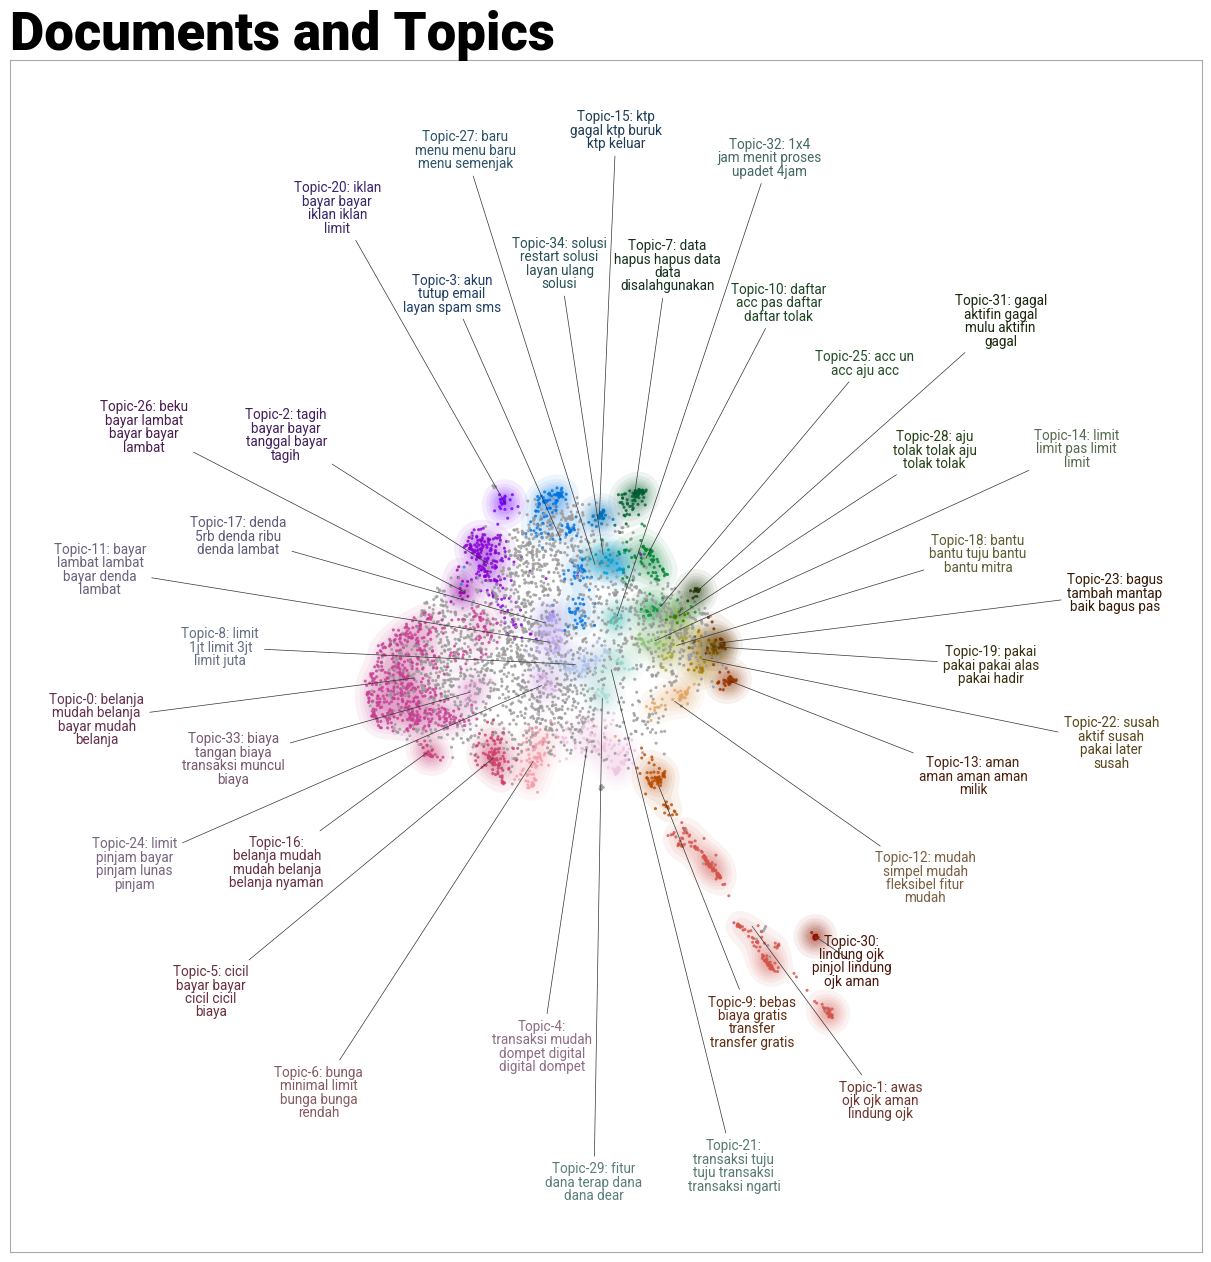

In [ ]:
fig = topic_model.visualize_document_datamap(docs, embeddings=embeddings)
fig.savefig("docs_datamap.png", bbox_inches="tight")

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[9], topic_token_distr[9])
df

100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


,solusi,bayar,praktis,terpercaya,proses,daftar,mudah,limit,cepat,tuju,transaksi,daring,offline,bunga,kompetitif,tenor,cicil,fleksibel,buat,bantu,butuh,desak,layan,langgan,responsif,ramah,puas,mudah,hidup
4_transaksi mudah_dompet digital_digital dompet_mudah transaksi,0.000,0.000,0.000,0.130,0.280,0.421,0.535,0.406,0.255,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_cicil bayar_bayar cicil_cicil biaya_cicil lunas,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.116,0.217,0.319,0.319,0.203,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_bunga minimal_limit bunga_bunga rendah_bunga mahal,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.110,0.217,0.327,0.456,0.346,0.239,0.128,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8_limit 1jt_limit 3jt_limit juta_juta limit,0.000,0.000,0.000,0.000,0.000,0.000,0.112,0.218,0.218,0.218,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10_daftar acc_pas daftar_daftar tolak_tawar daftar,0.000,0.000,0.000,0.105,0.221,0.331,0.331,0.226,0.110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16_belanja mudah_mudah belanja_belanja nyaman_belanja bayar,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.112,0.112,0.112,0.112,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21_transaksi tuju_tuju transaksi_transaksi ngarti_transfer beli,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.113,0.223,0.326,0.326,0.212,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# **5. Evaluation**

## **a. Cophenetic Correlation Coefficient**

In [ ]:
# Import necessary functions from the scipy library
# - `pdist`: Computes pairwise distances between observations in a dataset.
# - `linkage`: Performs hierarchical/agglomerative clustering on a condensed distance matrix.
# - `cophenet`: Calculates the Cophenetic Correlation Coefficient, which measures how well the hierarchical clustering preserves the original pairwise distances.
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet

In [ ]:
# Calculate the condensed distance matrix
# - `reduced_embeddings`: The input data, typically a 2D array where each row represents a data point in a lower-dimensional space (after UMAP reduction).
# - `metric='cosine'`: Specifies the distance metric to use. Cosine distance is chosen because it is well-suited for comparing text embeddings, as it focuses on the orientation (angle) of vectors rather than their magnitude.
condensed_distance_matrix = pdist(reduced_embeddings, metric='cosine')

In [ ]:
# Perform hierarchical clustering using the "average" linkage method
# - `condensed_distance_matrix`: The pairwise distance matrix computed by `pdist`.
# - `method='average'`: Specifies the linkage method to use. The "average" method calculates the average distance between all pairs of points in two clusters.
# - `Z`: The resulting linkage matrix, which encodes the hierarchical clustering as a tree (dendrogram).
Z = linkage(condensed_distance_matrix, method='average')

In [ ]:
# Calculate the Cophenetic Correlation Coefficient
# - `Z`: The linkage matrix from hierarchical clustering.
# - `condensed_distance_matrix`: The original pairwise distance matrix.
# - `c`: The Cophenetic Correlation Coefficient, which measures how well the hierarchical clustering preserves the original pairwise distances. A value close to 1 indicates a strong correlation.
# - `coph_dists`: The cophenetic distances, which represent the pairwise distances between points in the hierarchical clustering tree.
c, coph_dists = cophenet(Z, condensed_distance_matrix)
print(f'Cophenetic Correlation Coefficient: {c}')

Cophenetic Correlation Coefficient: 0.8387748808812092


## **b. Coherence Score**

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
# Define a function to compute coherence scores for each topic label
def compute_coherence(df):
    """
    Computes the coherence score for each topic label in the DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing at least two columns:
                           - 'factor_label': The topic label assigned to each document.
                           - 'content': The text content of each document.

    Returns:
        dict: A dictionary where keys are topic labels and values are their corresponding coherence scores.
    """
    coherence_scores = {}  # Dictionary to store coherence scores for each topic label

    # Filter out rows with the label 'Outlier' (if any)
    filtered_df = df[df['factor_label'] != 'Outlier']

    # Iterate over each unique topic label
    for label in filtered_df['factor_label'].unique():
        # Extract and preprocess the text content for the current topic label
        # - Split each document into a list of words (tokenization)
        texts = filtered_df[filtered_df['factor_label'] == label]['content'].apply(lambda x: x.split()).tolist()

        # Create a dictionary mapping of terms to their integer IDs
        dictionary = Dictionary(texts)

        # Convert the tokenized texts into a bag-of-words (BoW) corpus
        corpus = [dictionary.doc2bow(text) for text in texts]

        # Compute TF-IDF scores for the terms in the corpus
        tfidf = TfidfModel(corpus)

        # Extract the top 10 words for each document based on TF-IDF scores
        top_words = [
            [dictionary[word_id] for word_id, _ in sorted(tfidf[doc], key=lambda x: x[1], reverse=True)[:10]]
            for doc in corpus
        ]

        # Compute the coherence score for the current topic label
        # - `topics=top_words`: The top words for each document.
        # - `texts=texts`: The tokenized texts.
        # - `dictionary=dictionary`: The dictionary mapping terms to IDs.
        # - `coherence='c_v'`: The coherence measure to use ('c_v' is a popular choice).
        coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores[label] = coherence_model.get_coherence()  # Store the coherence score

    return coherence_scores  # Return the dictionary of coherence scores

In [ ]:
df_combined=pd.read_csv('combined_results_rf.csv')

In [ ]:
# Calculate coherence scores
coherence_scores = compute_coherence(df_combined)

In [ ]:
coherence_scores

{'AA': 0.8333943336710999,
 'AE': 0.9190942829672094,
 'EU': 0.847686891929867,
 'UP': 0.7408403150715055,
 'AC': 0.8625691657079482,
 'CA': 0.8109533510361825,
 'AP': 0.8336776780068472,
 'CLA': 0.8623164003108791,
 'AR': 0.87506068902669,
 'AF': 0.9079286547057237}

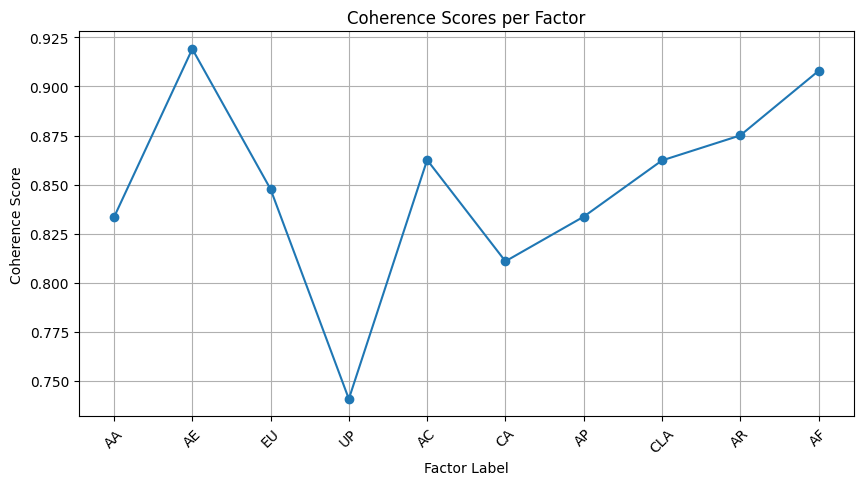

In [ ]:
# Plot Coherence Scores
plt.figure(figsize=(10, 5))
plt.plot(coherence_scores.keys(), coherence_scores.values(), marker='o', linestyle='-')
plt.xlabel('Factor Label')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores per Factor')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# **6. Re-classifying**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Mean Pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
# Dataset class for batching
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [ ]:
# Function to process data in batches
def get_embeddings(data_loader, model, tokenizer, device):
    embeddings = []
    for texts in tqdm(data_loader, desc="Processing batches"):
        encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
        encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask']).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [ ]:
# Load dataset
df = pd.read_csv('/content/bnpl dataset - original data labeled.csv', usecols=['content', 'factor_label'])
train_df = df[df['factor_label'] != 'Outlier'].reset_index(drop=True)
test_df = df[df['factor_label'] == 'Outlier'].reset_index(drop=True)

In [ ]:
# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('firqaaa/indo-sentence-bert-base')
model = AutoModel.from_pretrained('firqaaa/indo-sentence-bert-base').to(device)  # Move model to GPU if available

# Create DataLoaders for batching
batch_size = 16
train_loader = DataLoader(TextDataset(train_df['content'].tolist()), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TextDataset(test_df['content'].tolist()), batch_size=batch_size, shuffle=False)

# Get embeddings in batches
train_embeddings = get_embeddings(train_loader, model, tokenizer, device)
test_embeddings = get_embeddings(test_loader, model, tokenizer, device)

Processing batches: 100%|██████████| 133/133 [00:08<00:00, 14.99it/s]


In [ ]:
# Prepare target columns
y_train = train_df['factor_label'].values

In [ ]:
# Train classifier using tqdm for progress bar
clf = RandomForestClassifier()
clf.fit(train_embeddings, y_train)

RandomForestClassifier()

In [ ]:
# Make predictions
test_predictions = clf.predict(test_embeddings)

# Add results to test dataframe
test_df['factor_label_pred'] = test_predictions

In [ ]:
# Combine train and test data
train_df['factor_label_pred'] = train_df['factor_label']  # Keep original labels for train data
df_combined = pd.concat([train_df, test_df], ignore_index=True)

# Save combined results
df_combined.to_csv("combined_results_rf.csv", index=False)

print(df_combined[['content', 'factor_label', 'factor_label_pred']])

                                                content factor_label  \
0     banyak spam telpon untuk promosi ajakan buka a...          RGE   
1     buruk ketika saya ingin membayar saya iklan se...          ADE   
2     saya menerima sms dari bank yang menyatakan ba...          RGE   
3       bank adalah yang terbaik sangat mudah digunakan          EOU   
4     selalu error jaringan saat foto ktp untuk akti...          RGE   
...                                                 ...          ...   
4483               tolong ya kak akun saya di kasih nya      Outlier   
4484  sudah langganan tetap untuk pengambilan elektr...      Outlier   
4485                    tidak dapat limit hci malas deh      Outlier   
4486  tidak bersahabat dan sudah login tgg one time ...      Outlier   
4487   kualitas makin buruk 3 ribu juga 78 ribu x lipat      Outlier   

     factor_label_pred  
0                  RGE  
1                  ADE  
2                  RGE  
3                  EOU  
4         